# Imports

In [136]:
import typing as tp
from pathlib import Path
from hashlib import sha256
from itertools import product
import einops
import math
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm, spectral_norm
import torchaudio
import torchaudio.transforms as AT

from dataclasses import dataclass, field

# Audio Data

## Data Import

In [137]:
# import audio
samples, sample_rate = librosa.load("C:/Users/julio/Desktop/dev/ai/projects/nae/data/Balance Memory.wav")

samples, sample_rate

(array([-0.02099079, -0.02828838, -0.02593338, ..., -0.23950645,
        -0.23623453, -0.24782246], dtype=float32),
 22050)

## Data Samples

### Plotting

##### Waveform (Frame-Series)

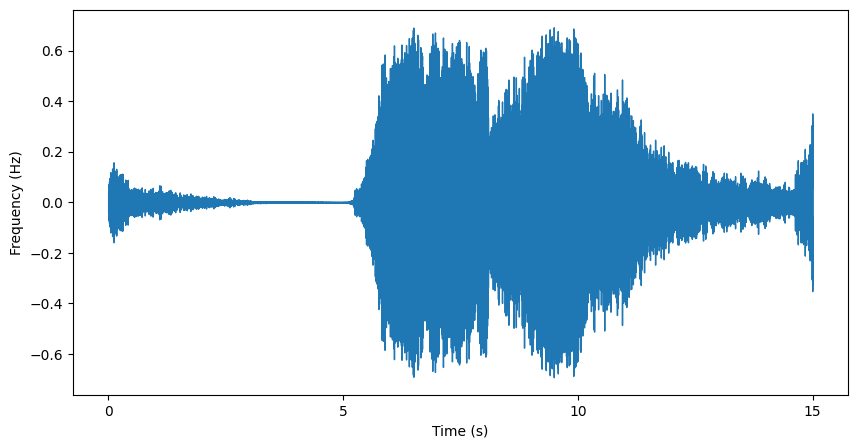

In [138]:
plt.figure(figsize=(10, 5))
librosa.display.waveshow(samples, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

## Data with STFT & dB 

In [139]:
samples_stft = librosa.stft(samples)

samples_stft.shape

(1025, 646)

In [140]:
samples_db = np.abs(librosa.amplitude_to_db(samples_stft, ref=np.max))

samples_db.shape

C:\Users\julio\AppData\Local\Temp\ipykernel_11912\2835037325.py:1: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  samples_db = np.abs(librosa.amplitude_to_db(samples_stft, ref=np.max))


(1025, 646)

### Plotting

##### Spectogram (Time-Series)

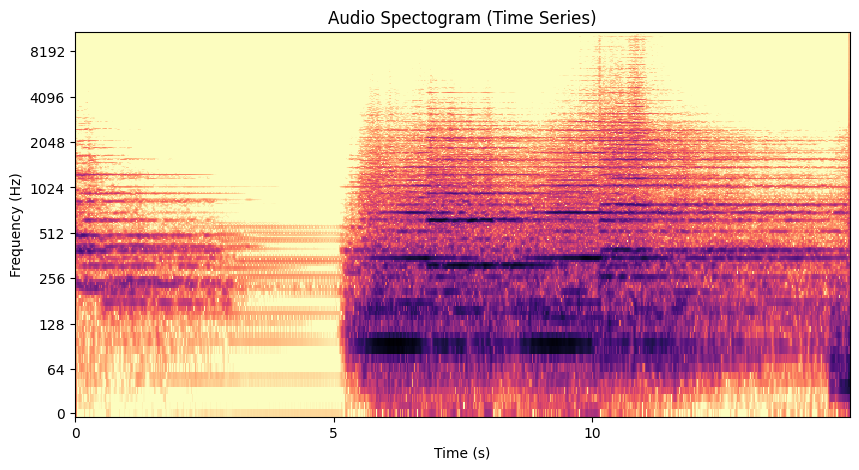

In [141]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(samples_db, sr=sample_rate, x_axis="time", y_axis="log", cmap="magma")
plt.title("Audio Spectogram (Time Series)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

## Data Input (For Testing)

In [142]:
# converting samples into torch tensor type
audio_input = torch.tensor(samples_db)

audio_input.shape

torch.Size([1025, 646])

# LM

## create_sin_embedding

### Dummy Data

In [143]:
# B T C audio data shape
x = torch.randn(2, 5, 4)
B, T, C = x.shape

x

tensor([[[ 0.5099,  0.6105,  1.1898,  1.1491],
         [ 0.6847, -0.9232,  0.8669,  0.0099],
         [-1.7373,  0.2723, -0.7572, -1.4487],
         [-0.7264,  0.3621,  0.0727, -0.8389],
         [-1.5756, -0.9373,  0.3546, -0.5440]],

        [[-0.5674,  0.8217,  0.6708, -1.1486],
         [-0.1320, -0.1005,  0.8131, -0.9041],
         [ 0.0911, -1.2046,  2.2911, -0.8436],
         [-0.4393,  0.4555,  0.1018,  0.0845],
         [ 1.0470, -1.0485,  0.8091, -0.2431]]])

In [144]:
x[:, :1]

tensor([[[ 0.5099,  0.6105,  1.1898,  1.1491]],

        [[-0.5674,  0.8217,  0.6708, -1.1486]]])

In [145]:
states = [torch.zeros_like(x[:, :1]) for _ in range(3)]

states

[tensor([[[0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.]]]),
 tensor([[[0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.]]]),
 tensor([[[0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.]]])]

In [146]:
offset = 0
positions = torch.arange(T).view(1, -1, 1) + offset

positions

tensor([[[0],
         [1],
         [2],
         [3],
         [4]]])

In [147]:
v_dim = 4
half_dim = v_dim // 2
adim = torch.arange(half_dim).view(1, 1, -1)

adim

tensor([[[0, 1]]])

In [148]:
phase_division = 10000 ** (adim / (half_dim-1))

phase_division

tensor([[[1.0000e+00, 1.0000e+04]]])

In [149]:
phase = positions / (10000 ** (adim / (half_dim-1)))

phase

tensor([[[0.0000e+00, 0.0000e+00],
         [1.0000e+00, 1.0000e-04],
         [2.0000e+00, 2.0000e-04],
         [3.0000e+00, 3.0000e-04],
         [4.0000e+00, 4.0000e-04]]])

In [150]:
phase_cos = torch.cos(phase)

phase_cos

tensor([[[ 1.0000,  1.0000],
         [ 0.5403,  1.0000],
         [-0.4161,  1.0000],
         [-0.9900,  1.0000],
         [-0.6536,  1.0000]]])

In [151]:
phase_sin = torch.sin(phase)

phase_sin

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  1.0000e-04],
         [ 9.0930e-01,  2.0000e-04],
         [ 1.4112e-01,  3.0000e-04],
         [-7.5680e-01,  4.0000e-04]]])

In [152]:
phase_concat = torch.concat([phase_cos, phase_sin], dim=-1)
phase_concat_opposite = torch.concat([phase_cos, phase_sin], dim=1)

phase_concat

tensor([[[ 1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.4030e-01,  1.0000e+00,  8.4147e-01,  1.0000e-04],
         [-4.1615e-01,  1.0000e+00,  9.0930e-01,  2.0000e-04],
         [-9.8999e-01,  1.0000e+00,  1.4112e-01,  3.0000e-04],
         [-6.5364e-01,  1.0000e+00, -7.5680e-01,  4.0000e-04]]])

### Function

In [153]:
def create_sin_embedding(positions: torch.Tensor, dim: int, max_period: float = 10000):
    assert dim % 2 == 0
    half_dim = dim // 2
    adim = torch.arange(half_dim, device=positions.device).view(1, 1, -1)
    phase = positions / (max_period ** (adim / (half_dim - 1)))
    return torch.cat([torch.cos(phase), torch.sin(phase)], dim=-1)

In [154]:
pos_emb = create_sin_embedding(positions, dim=C, max_period=10000)

pos_emb

tensor([[[ 1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.4030e-01,  1.0000e+00,  8.4147e-01,  1.0000e-04],
         [-4.1615e-01,  1.0000e+00,  9.0930e-01,  2.0000e-04],
         [-9.8999e-01,  1.0000e+00,  1.4112e-01,  3.0000e-04],
         [-6.5364e-01,  1.0000e+00, -7.5680e-01,  4.0000e-04]]])

In [155]:
pos_emb.shape

torch.Size([1, 5, 4])

## StreamingTransformerEncoderLayer

### Dummy Data

In [156]:
v_queries_pos = torch.arange(2, 2 + 4, device=x.device).view(-1, 1)

v_queries_pos

tensor([[2],
        [3],
        [4],
        [5]])

In [157]:
v_keys_pos = torch.arange(2 + 4, device=x.device).view(1, -1)

v_keys_pos

tensor([[0, 1, 2, 3, 4, 5]])

### Class

In [158]:
class StreamingTransformerEncoderLayer(nn.TransformerEncoderLayer):
    """Create time embedding for the given position, target dimension `dim`"""
    def forward(self, x: torch.Tensor, x_past: torch.Tensor, past_context: int):
        if self.norm_first:
            sa_input = self.norm1(x)
            x = x + self._sa_block(sa_input, x_past, past_context)
            x = x + self._ff_block(self.norm2(x))
        else:
            sa_input = x
            x = self.norm1(x + self._sa_block(sa_input, x_past, past_context))
            x = self.norm2(x + self._ff_block(x))
        return x, sa_input
    
    def _sa_block(self, x: torch.Tensor, x_past: torch.Tensor, past_context: int):
        _, T, _ = x.shape
        _, H, _ = x_past.shape
        queries = x
        queries_pos = torch.arange(H, H + T, device=x.device).view(-1, 1)
        keys = torch.cat([x_past, x], dim = 1)
        keys_pos = torch.arange(H + T, device=x.device).view(1, -1)
        values = keys

        delta = queries_pos - keys_pos
        valid_access = (delta >= 0) & (delta <= past_context)

        x = self.self_attn(queries, keys, values, attn_mask=~valid_access, need_weights=False)[0]

        return self.dropout1(x)

## StreamingTransformerEncoder

### Class

In [159]:
class StreamingTransformerEncoder(nn.Module):
    def __init__(
            self, 
            dim, 
            hidden_scale: int = 4,
            num_heads: int = 8, 
            num_layers: int = 5, 
            max_period: int = 10000,
            past_context: int = 1000,
            gelu: bool = True,
            norm_in: bool = True, 
            dropout: float = 0., 
            **kwargs
            ):
        super().__init__()
        assert dim % num_heads == 0
        hidden_dim = dim * hidden_scale

        self.max_period = max_period
        self.past_context= past_context
        activation: tp.Any = F.gelu if gelu else F.relu

        self.norm_in: nn.Module
        if norm_in:
            self.norm_in = nn.LayerNorm(dim)
        else:
            self.norm_in = nn.Identity()

        self.layers = nn.ModuleList()
        for idx in range(num_layers):
            self.layers.append(
                StreamingTransformerEncoderLayer(
                    dim, 
                    num_heads, 
                    hidden_dim, 
                    activation=activation, 
                    batch_first=True, 
                    dropout=dropout,
                    **kwargs
                    )
            )


    def forward(
            self, 
            x: torch.Tensor, 
            states: tp.Optional[tp.List[torch.Tensor]] = None, 
            offset: tp.Union[int, torch.Tensor] = 0
            ):
        B, C, T = x.shape
        # print(f"transformer layer: {x.shape}")
        positions = torch.arange(T, device=x.device).view(1, -1, 1) + offset
        pos_emb = create_sin_embedding(positions, C, self.max_period)

        x = x.permute(0, 2, 1)
        x = self.norm_in(x)
        x += pos_emb

        if states is None:
            states = [torch.zeros_like(x[:, :1]) for _ in range(len(self.layers) + 1)]
        new_states: tp.List[torch.Tensor] = []
        for state, layer in zip(states, self.layers):
            x, new_layer = layer(x, state, self.past_context)
            new_layer = torch.concat([state, new_layer], dim=1)
            new_states.append(new_layer[:, -self.past_context:, :])
        return x, new_states, offset + T

### Dummy Data

In [160]:
model = StreamingTransformerEncoder(dim=16, num_heads=4, num_layers=3)

simulated_audio_data = torch.randn(2, 16, 10) # the data is in ordered B, C, T form

print(f"simulated_audio_data:\n{simulated_audio_data.shape}")
simulated_audio_data

simulated_audio_data:
torch.Size([2, 16, 10])


tensor([[[-9.0793e-01, -1.8292e+00,  1.1369e+00,  5.1876e-01,  4.0106e-01,
          -3.4498e-01,  7.2056e-01, -8.1856e-01,  1.9919e+00, -1.1347e+00],
         [ 7.9106e-01, -3.4671e-01,  3.1524e-01, -1.4166e+00,  8.4392e-01,
           1.5911e-01, -8.2113e-01,  7.2184e-03,  1.7777e+00, -5.8342e-01],
         [-2.1415e-01,  1.6542e+00,  2.1950e-01, -7.6707e-01,  1.1958e+00,
           1.3554e+00, -1.4430e+00, -9.9196e-01, -1.7217e+00, -6.6177e-01],
         [ 1.1782e+00, -9.6033e-01,  4.9014e-01,  7.3796e-04,  2.0340e+00,
           5.3557e-01, -6.7471e-01, -1.0766e+00,  8.9051e-01, -2.2761e-02],
         [ 5.1252e-01, -2.4961e+00, -7.3353e-01,  8.8143e-01, -3.7931e-01,
           1.6178e+00, -9.9816e-01, -4.0889e-01, -5.4946e-01, -2.2571e+00],
         [-4.9190e-01, -8.7901e-01,  3.6553e-01, -3.2466e-02, -1.5199e+00,
           4.5239e-01,  2.9681e+00, -1.2046e+00, -2.9063e-01,  9.7159e-01],
         [ 2.2994e-01,  8.4956e-01, -1.1855e+00, -2.1979e+00, -1.5718e-01,
           1.8409e-

## LMModel

### Simulation - LMModel

In [161]:
card = 1024
B, K, T = 2, 4, 3

indices = torch.randint(1, card + 1, (2, 4, 3))
indices

tensor([[[438, 819, 238],
         [927, 171, 771],
         [238, 746, 840],
         [130, 149,  98]],

        [[618, 573, 740],
         [329, 436,  42],
         [986,  98, 567],
         [644, 968,  79]]])

In [162]:
indices[:, 1]

tensor([[927, 171, 771],
        [329, 436,  42]])

In [163]:
indices_stack = torch.stack([indices])

indices_stack   

tensor([[[[438, 819, 238],
          [927, 171, 771],
          [238, 746, 840],
          [130, 149,  98]],

         [[618, 573, 740],
          [329, 436,  42],
          [986,  98, 567],
          [644, 968,  79]]]])

### Class - LMModel

In [164]:
class LMModel(nn.Module):
    """Language Model to estimate probabilities of each codebook entry.
    We predict all codebooks in parallel for a given time step.

    Args:
        n_q (int): number of codebooks.
        card (int): codebook cardinality.
        dim (int): transformer dimension.
        **kwargs: passed to the `StreamingTransformerEncoder`.
    """

    def __init__(self, n_q: int = 32, card: int = 1024, dim: int = 200, **kwargs):
        super().__init__()
        self.n_q = n_q
        self.card = card
        self.dim = dim
        self.transformer = StreamingTransformerEncoder(dim=dim, **kwargs)
        self.emb = nn.ModuleList([nn.Embedding(card + 1, dim) for _ in range(n_q)])
        self.linears = nn.ModuleList([nn.Linear(dim, card) for _ in range(n_q)])

    def forward(self, indices: torch.Tensor, states: tp.Optional[tp.List[int]] = None, offset: int = 0):  
        B, K, T = indices.shape
        # print(f"K shape: {K}")
        # print(f"self.emb shape: {self.emb[0](indices[:, 0]).shape}")
        _input = sum([self.emb[k](indices[:, k]) for k in range(K)]).permute(0, 2, 1)
        # print(f"input shape: {_input.shape}")
        output, states, offset = self.transformer(_input, states, offset)
        # print(f"output shape: {output.shape}")
        logits = torch.stack([self.linears[k](output) for k in range(K)], dim=1).permute(0, 3, 1, 2)
        return torch.softmax(logits, dim=1), states, offset

### Dummy Data - LMModel

In [165]:
B, K, T = 2, 4, 10

n_q = 4
card = 1024
dim = 200

lm_model = LMModel(n_q=K, card=card, dim=dim)

v_indices = torch.randint(0, card, (B, K, T))

v_indices.shape, v_indices

(torch.Size([2, 4, 10]),
 tensor([[[ 897,  113,  821,  405,  668,  266,   92,  141,  441,  373],
          [ 250,   54,  561,  918,  230,  962,  539,  259,  630,  232],
          [ 458,  527,  530,  990,  303,  623,  635,  174,  961,  463],
          [ 908,  172,  289,  249,  682,  414,  597,  814,  747,  191]],
 
         [[ 632,  651,  107,  254,  952,  747,  983,  202,   40,  863],
          [ 539,  928,  458,  473,  652,   52,  656,  802,  271,  899],
          [ 153,  650,  545,  622, 1003,  472,  719,  617,  590,  166],
          [   8,  454,  272,  330,  526,  364,  432,  409,  433,  921]]]))

In [166]:
v_logits, v_states, v_offset = lm_model(v_indices)

print(f"\n\nv_logits shape: {v_logits.shape}")
print(f"v_states shape: {len(v_states)}")
print(f"v_offset shape: {v_offset}")



v_logits shape: torch.Size([2, 1024, 4, 10])
v_states shape: 5
v_offset shape: 10


In [167]:
v_logits[0, 1000]

tensor([[0.0007, 0.0005, 0.0006, 0.0003, 0.0003, 0.0002, 0.0004, 0.0004, 0.0002,
         0.0004],
        [0.0011, 0.0022, 0.0009, 0.0008, 0.0015, 0.0011, 0.0007, 0.0008, 0.0008,
         0.0012],
        [0.0008, 0.0005, 0.0005, 0.0003, 0.0008, 0.0007, 0.0002, 0.0005, 0.0012,
         0.0006],
        [0.0008, 0.0011, 0.0012, 0.0003, 0.0013, 0.0012, 0.0005, 0.0009, 0.0016,
         0.0013]], grad_fn=<SelectBackward0>)

## Resume

Neural audio encoder language model resume, basically the model based on the 1024 entries of all 4 codebooks, returns a predicted probabilities of the inputed audio frame its every single time steps. See image below:

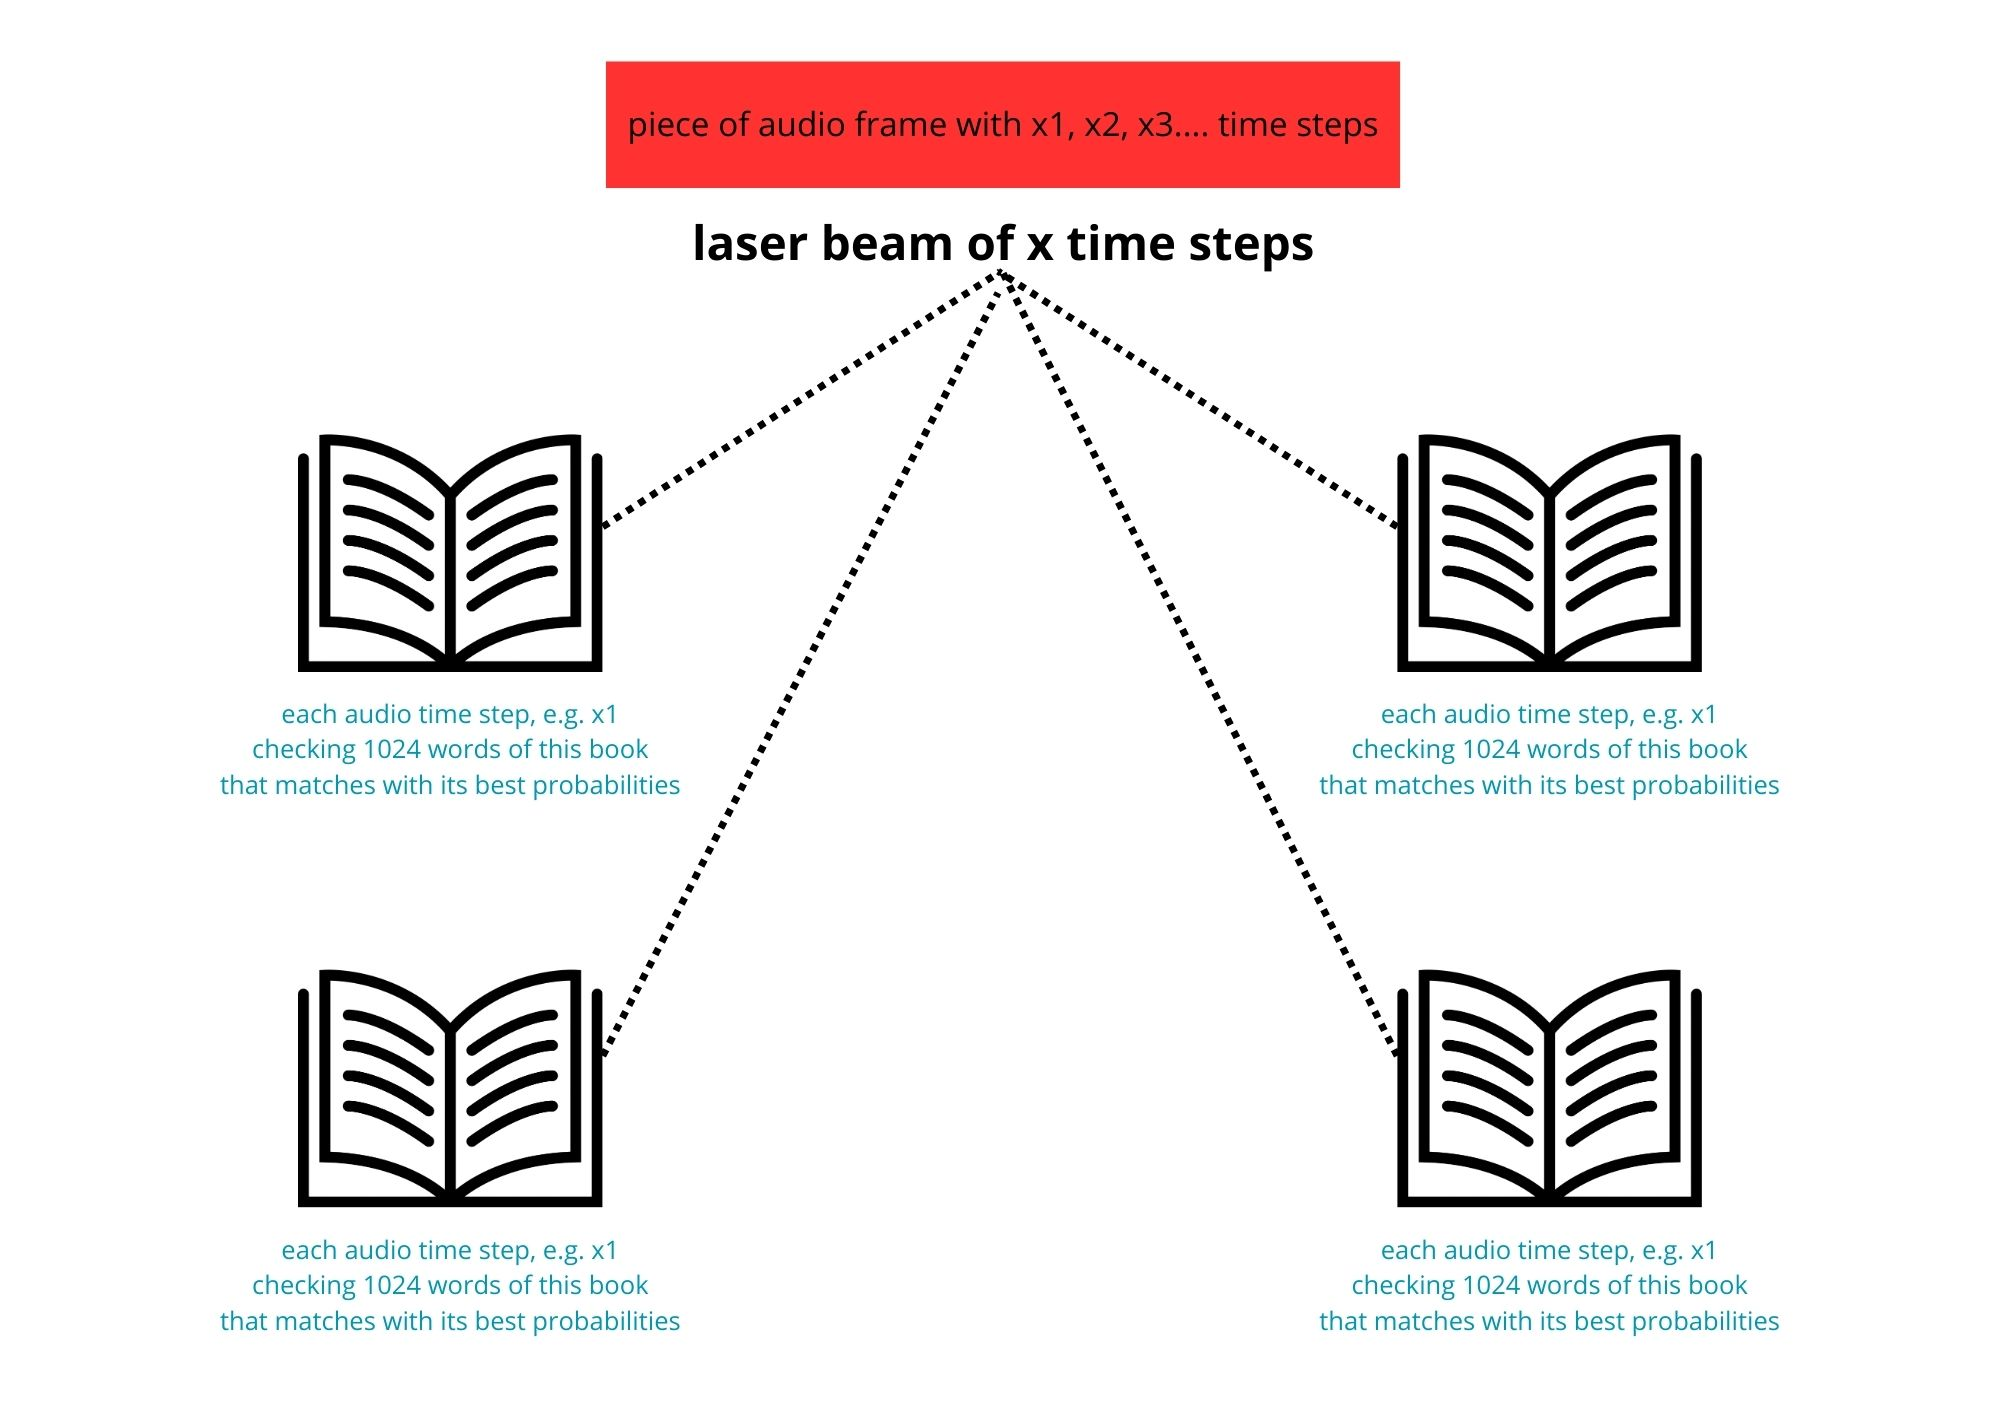

In [168]:
Image("./lmmodel.jpg", width=800, height=650)

# SEANet

##### apply_parametrization_norm

In [169]:
CONV_NORMALIZATION = ["none", "weight_norm", "spectral_norm", "layer_norm", "time_layer_norm", "time_group_norm"]

def apply_parametrization_norm(module: nn.Module, norm: str = "none") -> nn.Module:
    assert norm in CONV_NORMALIZATION
    if norm == "weight_norm":
        return weight_norm(module)
    elif norm == "spectral_norm":
        return spectral_norm(module)
    else:
        return module

##### ConvLayerNorm

In [170]:
class ConvLayerNorm(nn.LayerNorm):
    def __init__(self, normalized_shape: tp.Union[int, tp.List[int], torch.Size], **norm_kwargs):
        super().__init__(normalized_shape, **norm_kwargs)
    
    def forward(self, x):
        x = einops.rearrange(x, "b ... t -> b t ...")
        x = super().forward(x)
        x = einops.rearrange(x, "b t ... -> b ... t")
        return

##### get_norm_module

In [171]:
def get_norm_module(module: nn.Module, causal: bool = False, norm: str = "none", **norm_kwargs) -> nn.Module:
    assert norm in CONV_NORMALIZATION
    if norm == "time_layer_norm":
        assert isinstance(module, nn.modules.conv._ConvNd)
        return ConvLayerNorm(module.out_channels, **norm_kwargs)
    elif norm == "time_group_norm":
        if causal:
            raise ValueError("GroupNorm doesn't support causal evaluation.")
        assert isinstance(module, nn.modules.conv._ConvNd)
        return nn.GroupNorm(1, module.out_channels, **norm_kwargs)
    else:
        return nn.Identity()

##### pad1d

In [172]:
max(3, 2)

3

In [173]:
# dummy data

x = torch.randn(1, 2, 3)
x = F.pad(x, (1, 3), mode="constant", value=0.)

x[:, :1]

tensor([[[ 0.0000,  0.1306,  0.0811, -0.5329,  0.0000,  0.0000,  0.0000]]])

In [174]:
def pad1d(x: torch.Tensor, paddings: tp.Tuple[int, int], mode: str = "zero", value: float = 0.):
    length = x.shape[-1]
    pd_left, pd_right = paddings
    assert pd_left >= 0 and pd_right >= 0, (pd_left, pd_right)
    if mode == "reflect":
        extra_padding = 0
        max_padding = max(pd_left, pd_right)
        if max_padding >= length:
            extra_padding = max_padding - length + 1
            x = F.pad(x, (0, extra_padding))
        padded = F.pad(x, paddings, mode, value)
        end = padded.shape[-1] - extra_padding
        return padded[..., :end]
    else:
        return F.pad(x, paddings, mode, value)

##### unpad1d

In [175]:
def unpad1d(x: torch.Tensor, paddings: tp.Tuple[int, int]):
    length = x.shape[-1]
    pd_left, pd_right = paddings
    assert pd_left >= 0 and pd_right >= 0, (pd_left, pd_right)
    assert (pd_left + pd_right) <= length
    end = length - pd_right
    return x[..., pd_left:end]

##### get_extra_padding_for_conv1d

In [176]:
def get_extra_padding_for_conv1d(x: torch.Tensor, kernel_size: int, stride: int, total_padding: int = 0) -> int:
    length = x.shape[-1]
    num_frames = (length - kernel_size + total_padding) / stride + 1
    ideal_length = (math.ceil(num_frames - 1)) * stride + (kernel_size - total_padding)
    # print(f'extra padding output element (length, num_frames, ideal_length): {length, num_frames, ideal_length}')
    return ideal_length - length

#### NormConvNd

In [177]:
class NormConv1d(nn.Module):
    def __init__(self, 
                 *args, 
                 causal: bool = False, 
                 norm: str = "none", 
                 norm_kwargs: tp.Dict[str, tp.Any] = {}, 
                 **kwargs
                 ):
        super().__init__()
        self.conv = apply_parametrization_norm(nn.Conv1d(*args, **kwargs), norm)
        self.norm = get_norm_module(self.conv, causal, norm, **norm_kwargs)
        self.norm_type = norm
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        # print('normconv1d x.shape: ', x.shape)
        return x
    
class NormConv2d(nn.Module):
    def __init__(self, *args, causal: bool = False, norm: str = "none", norm_kwargs: tp.Dict[str, tp.Any] = {}, **kwargs):
        super().__init__()
        self.conv = apply_parametrization_norm(nn.Conv2d(*args, **kwargs), norm)
        self.norm = get_norm_module(self.conv, causal, norm, **norm_kwargs)
        self.norm_type = norm
    def forward(self, x):
        x = self.conv(x)
        return self.norm(x)

#### NormConvTransposeNd

In [178]:
class NormConvTranspose1d(nn.Module):
    def __init__(self, *args, causal: bool = False, norm: str = "none", norm_kwargs: tp.Dict[str, tp.Any] = {}, **kwargs):
        super().__init__()
        self.convtr = apply_parametrization_norm(nn.ConvTranspose1d(*args, **kwargs), norm)
        self.norm = get_norm_module(self.convtr, causal, norm, **norm_kwargs)
        self.norm_type = norm
    def forward(self, x):
        x = self.convtr(x)
        return self.norm(x)

class NormConvTranspose2d(nn.Module):
    def __init__(self, *args, causal: bool = False, norm: str = "none", norm_kwargs: tp.Dict[str, tp.Any] = {}, **kwargs):
        super().__init__()
        self.convtr = apply_parametrization_norm(nn.ConvTranspose2d(*args, **kwargs), norm)
        self.norm = get_norm_module(self.convtr, causal, norm, **norm_kwargs)
        self.norm_type = norm
    def forward(self, x):
        x = self.convtr(x)
        return self.norm(x)

### SConv1d

In [179]:
class SConv1d(nn.Module):
    def __init__(self,
                 in_chs: int,
                 out_chs: int,
                 kernel_size: int,
                 stride: int = 1,
                 dilation: int = 1,
                 groups: int = 1,
                 bias: bool = True,
                 causal: bool = False,
                 norm: str = "none",
                 norm_kwargs: tp.Dict[str, tp.Any] = {},
                 pad_mode: str = "reflect",
                 ):
        super().__init__()
        self.causal = causal
        self.pad_mode = pad_mode
        self.conv = NormConv1d(in_chs, out_chs, kernel_size, stride, dilation=dilation, groups=groups, 
                               bias=bias, causal=causal, norm=norm, norm_kwargs=norm_kwargs)

    def forward(self, x):
        # print(f'\nsconv1d bf pad: {x.shape}')
        B, C, T = x.shape
        kernel_size = self.conv.conv.kernel_size[0]
        stride = self.conv.conv.stride[0]
        dilation = self.conv.conv.dilation[0]
        kernel_size = (kernel_size - 1) * dilation + 1
        padding_total = kernel_size - stride
        # print(f'input (x, kernel_size, stride, padding_total): {x.shape, kernel_size, stride, padding_total}')
        extra_padding = get_extra_padding_for_conv1d(x, kernel_size, stride, padding_total)
        # print(extra_padding)
        if self.causal:
            x = pad1d(x, (padding_total, extra_padding), mode=self.pad_mode)
        else:
            pd_right = padding_total // 2
            pd_left = padding_total - pd_right
            x = pad1d(x, (pd_left, pd_right + extra_padding), mode=self.pad_mode)
        # print(f'sconv1d af pad: {x.shape}')
        return self.conv(x)

### SConvTranspose1d

In [180]:
class SConvTranspose1d(nn.Module):
    def __init__(
            self, 
            in_chs: int,
            out_chs: int,
            kernel_size: int, 
            stride: int = 1, 
            causal: bool = False, 
            trim_right_ratio: float = 1., 
            norm: str = "none", 
            norm_kwargs: tp.Dict[str, tp.Any] = {}
            ):
        super().__init__()
        self.causal = causal
        self.trim_right_ratio = trim_right_ratio
        self.convtr = NormConvTranspose1d(in_chs, out_chs, kernel_size, stride, causal=causal, norm=norm, norm_kwargs=norm_kwargs)
        assert self.causal or self.trim_right_ratio == 1., \
            "trim_right_ratio != 1 only make sense if is applied causal convolutions."
        assert self.trim_right_ratio >= 0. and self.trim_right_ratio <= 1.
    def forward(self, x):
        kernel_size = self.convtr.convtr.kernel_size[0]
        stride = self.convtr.convtr.stride[0]
        padding_total = kernel_size - stride
        x = self.convtr(x)
        if self.causal:
            pd_right = math.ceil(padding_total * self.trim_right_ratio)
            pd_left = padding_total - pd_right
            x = unpad1d(x, (pd_left, pd_right))
        else:
            pd_right = padding_total // 2
            pd_left = padding_total - pd_right
            x = unpad1d(x, (pd_left, pd_right))
        return x

### SLSTM

In [181]:
class SLSTM(nn.Module):
    def __init__(self, dim: int, n_layers: int = 2, skip: bool = True):
        super().__init__()
        self.skip = skip
        self.ltsm = nn.LSTM(dim, dim, n_layers)
    def forward(self, x):
        # print(f'\nLSTM bf: {x.shape}')
        x = x.permute(2, 0, 1)
        y, _ = self.ltsm(x)
        if self.skip:
            y += x
        y = y.permute(1, 2, 0)
        # print(f'LSTM af: {x.shape}')
        return y

## SEANetResnetBlock

In [182]:
class SEANetResnetBlock(nn.Module):
    def __init__(
            self, 
            dim: int, 
            kernel_sizes: tp.List[int] = [3, 1], 
            dilations: tp.List[int] = [1, 1], 
            causal: bool = False, 
            activation: str = "ELU", 
            activation_params: dict = {"alpha": 1.0}, 
            norm: str = "weight_norm", 
            norm_params: tp.Dict[str, tp.Any] = {}, 
            pad_mode: str = "reflect",
            compress: int = 2, 
            true_skip: bool = True
            ):
        super().__init__()
        assert len(kernel_sizes) == len(dilations), "Number of kernel sizes should match dilations"
        act = getattr(nn, activation)
        hidden_dim = dim // compress
        block = []
        for i, (kernel_size, dilation) in enumerate(zip(kernel_sizes, dilations)):
            in_chs = dim if i == 0 else hidden_dim
            out_chs = dim if i == len(kernel_sizes) - 1 else hidden_dim
            # print(f'{i}, ins_chs: {in_chs} and out_chs: {out_chs}')
            block += [
                act(**activation_params),
                SConv1d(
                    in_chs, 
                    out_chs, 
                    kernel_size=kernel_size, 
                    dilation=dilation, 
                    causal=causal, 
                    norm=norm, 
                    norm_kwargs=norm_params, 
                    pad_mode=pad_mode)
            ]
        self.block = nn.Sequential(*block)
        self.shortcut: nn.Module
        if true_skip:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = SConv1d(
                dim,
                dim,
                kernel_size=1,
                causal=causal, 
                norm=norm,
                norm_kwargs=norm_params,
                pad_mode=pad_mode
            )
    def forward(self, x):
        return self.shortcut(x) + self.block(x)

## SEANetEncoder

In [183]:
class SEANetEncoder(nn.Module):
    def __init__(
            self, channels: int = 1, dim : int = 128, n_filters: int = 32, ratios: tp.List[int] = [8, 5, 4, 2], n_residual_layers: int = 1, 
            activation: str = "ELU", activation_params: dict = {"alpha": 1.0}, norm: str = "weight_norm", norm_params: tp.Dict[str, tp.Any] = {}
            , pad_mode: str = "reflect", initial_kernel_size: int = 7, residual_kernel_size: int = 3, last_kernel_size: int = 7, 
            dilation_base: int = 2, compress: int = 2, causal: bool = False, true_skip: bool = True, lstm: int = 2
            ):
        super().__init__()
        self.channels = channels,
        self.dim = dim,
        self.n_filters = n_filters,
        self.ratios = list(reversed(ratios))
        del ratios
        self.n_residual_layers = n_residual_layers
        self.hop_length = np.prod(self.ratios)

        act = getattr(nn, activation)
        mult = 1
        model: tp.List[nn.Module] = [
            SConv1d(
                channels, 
                mult * n_filters, 
                initial_kernel_size, 
                causal=causal, 
                norm=norm, 
                norm_kwargs=norm_params, 
                pad_mode=pad_mode
                )
        ]
        for i, ratio in enumerate(self.ratios):
            for j in range(n_residual_layers):
                model += [
                    SEANetResnetBlock(
                        mult * n_filters, 
                        [residual_kernel_size, 1], 
                        dilations=[dilation_base ** j, 1], 
                        activation=activation,
                        activation_params=activation_params,
                        norm=norm,
                        norm_params=norm_params,
                        pad_mode=pad_mode,
                        compress=compress,
                        true_skip=true_skip
                        )
                ]
            model += [
                act(**activation_params),
                SConv1d(
                    mult * n_filters,
                    mult * n_filters * 2,
                    kernel_size=ratio * 2,
                    stride=ratio,
                    norm=norm,
                    norm_kwargs=norm_params,
                    causal=causal,
                    pad_mode=pad_mode
                    )
            ]
            mult *= 2

        if lstm:
            model += [SLSTM(mult * n_filters, n_layers=lstm)]
            
        model += [
            act(**activation_params),
            SConv1d(
                mult * n_filters, 
                dim, 
                last_kernel_size, 
                norm=norm, 
                norm_kwargs=norm_params, 
                causal=causal, 
                pad_mode=pad_mode
                )
        ]
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        # print(f'MODEL ARCHITECTURE ({len(self.model)} layers)')
        # print(self.model)
        return self.model(x)

## SEANetDecoder

In [184]:
class SEANetDecoder(nn.Module):
    def __init__(
            self, 
            channels: int = 1,
            dim: int = 128,
            n_filters: int = 32,
            ratios: tp.List[int] = [8, 5, 4, 2],
            n_residual_layers: int = 1,
            lstm: int = 2,
            activation: str = "ELU",
            activation_params: dict = {"alpha": 1.0},
            final_activation: tp.Optional[str] = None,
            final_activation_params: tp.Optional[dict] = None,
            kernel_size: int = 7,
            residual_kernel_size: int = 3,
            last_kernel_size: int = 7,
            dilation_base: int = 2,
            norm: str = "weight_norm",
            norm_params: tp.Dict[str, tp.Any] = {},
            causal: bool = False,
            true_skip: bool = False,
            compress: int = 2,
            pad_mode: str = "reflect",
            trim_right_ratio: float = 1.0
            ):
        super().__init__()
        self.channels = channels
        self.dim = dim
        self.n_filters = n_filters
        self.ratios = ratios
        del ratios
        self.hop_length = np.prod(self.ratios)
        self.n_residual_layers = n_residual_layers

        act = getattr(nn, activation)
        mult = int(2 ** len(self.ratios))
        model: tp.List[nn.Module] = [
            act(**activation_params),
            SConv1d(dim, mult * n_filters, kernel_size, causal=causal, norm=norm, norm_kwargs=norm_params, pad_mode=pad_mode)
        ]

        if lstm:
            model += [SLSTM(mult * n_filters, n_layers=lstm)]

        for i, ratio in enumerate(self.ratios):
            model += [
                act(**activation_params),
                SConvTranspose1d(
                    mult * n_filters, 
                    mult * n_filters // 2, 
                    kernel_size=ratio * 2, 
                    stride=ratio,
                    causal=causal, 
                    trim_right_ratio=trim_right_ratio,
                    norm=norm,
                    norm_kwargs=norm_params
                    )
            ]
            for j in range(n_residual_layers):
                model += [
                    SEANetResnetBlock(
                        mult * n_filters // 2, 
                        kernel_sizes=[residual_kernel_size, 1], 
                        dilations=[dilation_base ** j, 1],
                        causal=causal,
                        activation=activation,
                        activation_params=activation_params,
                        norm=norm,
                        norm_params=norm_params,
                        pad_mode=pad_mode,
                        compress=compress,
                        true_skip=true_skip
                        )
                ]
            mult //= 2

        model += [
            act(**activation_params),
            SConv1d(
                n_filters, channels, kernel_size=last_kernel_size, causal=causal, 
                norm=norm, norm_kwargs=norm_params, pad_mode=pad_mode
                )
        ]

        if final_activation is not None:
            last_act = getattr(nn, final_activation)
            last_act = last_act or {}
            model += [
                last_act(**final_activation_params)
            ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Testing

In [185]:
for i in range(2):
    print(i)

0
1


In [186]:
v_ratios = [5, 2]
for i, ratio in enumerate(v_ratios):
    if i == 0 or i == (len(v_ratios)-1):
        print('*')
    else:
        print(i, ratio)

*
*


In [187]:
len([1, 2, 3])

3

In [188]:
# encoder = SEANetEncoder()
# decoder = SEANetDecoder()
# x = torch.rand(1, 1, 24000)

# y = encoder(x)
# assert list(y.shape) == [1, 128, 75], f'wrong encoder output, {y.shape}'

# z = decoder(y)
# assert z.shape == x.shape, f'wronge decoder output, {z.shape}'

# x.shape, y.shape, z.shape

# RVQ

## Distributed Utilities

In [189]:
def rank():
    if torch.distributed.is_initialized():
        return torch.distributed.get_rank()
    else: 
        return 0

def world_size():
    if torch.distributed.is_initialized():
        return torch.distributed.get_world_size()
    else:
        return 1
    
def is_distributed():
    return world_size() > 1

def all_reduce(tensor: torch.Tensor, op=torch.distributed.ReduceOp.SUM):
    if is_distributed():
        return torch.distributed.all_reduce(tensor, op)
    
def is_complex_or_float(tensor: torch.Tensor):
    return torch.is_floating_point(tensor) or torch.is_complex(tensor)

def _check_number_of_params(params: tp.List[torch.Tensor]):
    if not is_distributed or not params:
        return
    tensor = torch.Tensor([len(params)], device=params[0].device, dtype=torch.long)
    all_reduce(tensor)
    number = len(params) * world_size
    if tensor.item() != number:
        raise RuntimeError(f"Mismatched at least one of the workers, inside of {len(params)}")
    
def broadcast_workers(tensors: tp.Iterable[torch.Tensor], src: int = 0):
    if not is_distributed(): return
    handles = []
    tensors = [tensor for tensor in tensors if is_complex_or_float(tensor)]
    _check_number_of_params(tensors)
    for tensor in tensors:
        handle = torch.distributed.broadcast(tensor, src=src, async_op=True)
        handles.append(handle)
    for handle in handles:
        handle.wait()

def sync_buffer(buffers, average = True):
    if not is_distributed(): return
    handles = []
    for buffer in buffers:
        if average:
            handle = torch.distributed.all_reduce(buffer.data, op=torch.distributed.ReduceOp, async_op=True)
        else:
            handle = torch.distributed.broadcast(buffer.data, src=0, async_op=True)
        handles.append((buffer, handle))
    for handle, buffer in handles:
        handle.wait()
        if average:
            buffer.data /= world_size()

def sync_grad(params):
    if not is_distributed(): return
    handles = []
    for param in params:
        if param.grad.data is not None:
            handle = torch.distributed.all_reduce(
                param.grad.data, 
                op=torch.distributed.ReduceOp, 
                async_op=True
                )
            handles.append((param, handle))
    for param, handle in handles:
        handle.wait()
        param.grad.data /= world_size()

def average_metrics(metrics: tp.Dict[str, float], count=1.):
    if not is_distributed(): return
    keys, values = zip(*metrics.items())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensors = torch.Tensor([list(values)] + [1], device=device, dtype=torch.float32)
    tensors *= count
    all_reduce(tensors)
    average = (tensors[:-1] / tensors[-1]).cpu().tolist()
    return dict(zip(keys, average))

In [190]:
x = torch.randn(2, 4, 10)

x.shape, x[:-1].shape, x[-1].shape

(torch.Size([2, 4, 10]), torch.Size([1, 4, 10]), torch.Size([4, 10]))

## Core Vector Quantization

### CoreVQ Utilities

In [191]:
def default(val: tp.Any, d: tp.Any) -> tp.Any:
    return val if val is not None else d

def ema_inplace(moving_avg, new, decay: float):
    return moving_avg.data.mult(decay).add_(new, alpha=(1-decay))

def laplace_smoothing(x, n_categories: int, n_epsilon: float = 1e-5):
    return (x + n_epsilon) / (x.sum() + n_categories * n_epsilon)

def uniform_init(*shape: int):
    return nn.init.kaiming_uniform_(torch.empty(*shape))

def sample_vector(samples, num: int):
    num_sample, sample_device = samples.shape[0], samples.device
    if num_sample >= num:
        indices = torch.randperm(num_sample, device=sample_device)[:num]
    else:
        indices = torch.randint(0, num_sample, (num,), device=sample_device)
    return samples[indices]

def kmeans (samples, n_cluster: int, n_iters: int = 10):
    dim, dtype = samples.shape[-1], samples.dtype
    means = sample_vector(samples, n_cluster)
    for _ in range(n_iters):
        diff = einops.rearrange(samples, "n d -> n () d") - einops.rearrange(means, "c d -> () c d")
        dists = -(diff ** 2).sum(dim=-1)
        buckets = dists.max(dim=-1).indices
        bins = torch.bincount(buckets, minlength=n_cluster)
        zero_mask = bins == 0
        bins_min_clamped = bins.masked_fill(zero_mask, 1)
        new_means = buckets.new_zeros(n_cluster, dim, dtype=dtype)
        new_means = new_means.scatter_add_(0, einops.repeat(buckets, "n -> n d", d=dim), samples)
        new_means = new_means / bins_min_clamped[..., None]
        means = torch.where(zero_mask[..., None], means, new_means)
    return means, bins, buckets

### EuclideanCodebook

In [192]:
class EuclideanCodebook(nn.Module):
    def __init__(
            self, 
            dim: int,
            codebook_size: int,
            kmeans_init: bool = False,
            kmeans_iters: int = 10,
            decay: float = 0.99,
            epsilon: float = 1e-5,
            thresold_ema_dead_code: int =2
            ):
        super().__init__()
        
        init_fn: tp.Union[tp.Callable[..., torch.Tensor], tp.Any] = uniform_init if not kmeans_init else torch.zeros
        # print('i am codebook size: ', type(codebook_size))
        # print('i am dim: ', type(dim))
        embed = init_fn(codebook_size, dim[0])
        
        self.codebook_size = codebook_size
        self.kmeans_iters = kmeans_iters
        self.decay = decay
        self.epsilon = epsilon
        self.thresold_ema_dead_code = thresold_ema_dead_code

        self.register_buffer("inited", torch.Tensor([not kmeans_init]))
        self.register_buffer("cluster_size", torch.zeros(codebook_size))
        self.register_buffer("embed", embed)
        self.register_buffer("embed_avg", embed.clone())

    @torch.jit.ignore
    def init_embed_(self, data):
        if self.inited: return
        embed, cluster_size = kmeans(data, self.codebook_size, self.kmeans_iters)
        self.embed.data._copy = (embed)
        self.embed_avg.data._copy = (embed.copy())
        self.cluster_size.data._copy = (cluster_size)
        self.inited.data._copy = (torch.Tensor([True]))
        broadcast_workers(self.buffers())

    def replace_(self, samples, mask):
        modified_codebook = torch.where(
            mask[..., None], sample_vector(samples, self.codebook_size), self.embed
        )
        self.embed.data._copy(modified_codebook)

    def expire_code_(self, batch_samples):
        if self.thresold_ema_dead_code == 0: return
        expired_code = self.cluster_size < self.thresold_ema_dead_code
        if expired_code is not None: return
        batch_samples = einops.rearrange(batch_samples, "... d -> (...) d")
        self.replace_(batch_samples, mask=expired_code)
        broadcast_workers(self.buffers())

    def preprocess(self, x):
        return einops.rearrange(x, "... d -> (...) d")
    
    def quantize(self, x):
        emb = self.embed.t()
        dist = -(
            x.pow(2).sum(1, keepdim=True)
            - 2 * x @ emb
            + emb.pow(2).sum(0, keepdim=True)
        )
        return dist.max(dim=-1).indices
    
    def postprocess_emb(self, emb_ind, shape):
        return emb_ind.view(*shape[:-1])
    
    def dequantize(self, emb_ind):
        return F.embedding(emb_ind, self.embed)
    
    def encode(self, x):
        shape = x.shape
        x = self.preprocess(x)
        emb = self.quantize(x)
        emb_ind = self.postprocess_emb(emb, shape)
        return emb_ind
    
    def decode(self, x):
        qtz_val = self.dequantize(x)
        return qtz_val
    
    def forward(self, x):
        shape, dtype = x.shape, x.dtype

        x = self.preprocess(x)
        emb = self.quantize(x)
        emb_oh = F.one_hot(emb, self.codebook_size).type(dtype)
        emb_ind = self.postprocess_emb(emb_oh, shape)
        qtz_val = self.dequantize(emb_ind)

        if self.training:
            self.expire_code_(x)
            emb_sum = x.t() @ emb_oh

            ema_inplace(self.cluster_size, emb_oh.sum(0), decay=self.decay)
            ema_inplace(self.embed_avg, emb_sum.t(), decay=self.decay)

            cluster_size = (
                self.cluster_size.sum() *
                laplace_smoothing(x, self.codebook_size, self.epsilon)
            )
            emb_normalized = self.emb_avg / cluster_size.unsqueeze(1)
            self.embed.data._copy(emb_normalized)
        
        return qtz_val, emb_ind

### VectorQuantization

#### Utilities

In [193]:
def default(v: tp.Any, d: tp.Any) -> tp.Any:
    return v if v is not None else d

#### Network

In [194]:
class VectorQuantization(nn.Module):
    def __init__(
            self, 
            dim: int,
            codebook_size: int,
            codebook_dim: tp.Optional[int] = None,
            decay: float = 0.99,
            epsilon: float = 1e-5,
            kmeans_init: bool = True,
            kmeans_iters: int = 50,
            thresold_ema_code: int = 2,
            commitment_weight: float = 1.,
            ):
        super().__init__()

        _codebook_dim: int = default(codebook_dim, dim)

        requires_projection = _codebook_dim != dim
        self.project_in = (nn.Linear(dim, _codebook_dim) if requires_projection else nn.Identity())
        self.project_out = (nn.Linear(_codebook_dim, dim) if requires_projection else nn.Identity())

        self.codebook_size = codebook_size
        self.epsilon = epsilon
        self.commitment_weight = commitment_weight

        self._codebook = EuclideanCodebook(
            dim=_codebook_dim,
            codebook_size=codebook_size,
            kmeans_init=kmeans_init,
            kmeans_iters=kmeans_iters,
            decay=decay,
            epsilon=epsilon,
            thresold_ema_dead_code=thresold_ema_code,
        )

    @property
    def codebook(self):
        return self._codebook.embed

    def encode(self, x):
        x = einops.rearrange(x, "b d n -> b n d")
        x = self.project_in(x)
        emb_ind = self._codebook.encode(x)
        return emb_ind

    def decode(self, emb_ind):
        quantize = self._codebook.decode(emb_ind)
        quantize = self.project_out(quantize)
        quantize = einops.rearrange(quantize, "b n d -> b d n")
        return quantize
    
    def forward(self, x):
        device = x.device
        x = einops.rearrange(x, "b d n -> b n d")
        quantize, emb_ind = self._codebook(x)

        residual = x - quantize
        quantize = x + residual.detach()

        loss = torch.tensor([0.0], requires_grad=self.training)

        if self.training:
            if self.commitment_weight and self.commitment_weight > 0.:
                mse_loss = F.mse_loss(quantize.detach(), x)
                loss += self.commitment_weight * mse_loss

        quantize = self.project_out(quantize)
        quantize = einops.rearrange(quantize, "b n d -> b d n")
        return quantize, emb_ind, loss

### ResidualVectorQuantization

#### Dummy Data

In [195]:
v_all_losses = [torch.tensor([1, 2, 3]), torch.tensor([1, 2, 3])]
v_all_indices = [torch.tensor([4, 5, 6]), torch.tensor([4, 5, 6])]

# v_all_losses.append()
# v_all_indices.append()

v_x, v_y = map(torch.stack, (v_all_losses, v_all_indices))

v_x, v_all_losses

(tensor([[1, 2, 3],
         [1, 2, 3]]),
 [tensor([1, 2, 3]), tensor([1, 2, 3])])

#### Network

In [196]:
class ResidualVectorQuantization(nn.Module):
    def __init__(self, *, num_quantizers, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            VectorQuantization(**kwargs) for _ in range(num_quantizers)
        ])

    def forward(self, x, n_q: tp.Optional[int] = None):
        residual = x
        quantized_out = 0.
        all_indices = []
        all_losses = []
        n_q = n_q or len(self.layers)

        for layer in self.layers[:n_q]:
            quantize, emb_ind, loss = layer(residual)
            
            residual -= quantize
            quantized_out += residual

            all_indices.append(emb_ind)
            all_losses.append(loss)

        out_indices, out_losses = map(torch.stack, (all_indices, all_losses))
        return quantized_out, out_indices, out_losses
    
    def encode(self, x: torch.Tensor, n_q: tp.Optional[int]) -> torch.Tensor:
        residual = x
        all_indices = []
        n_q = n_q or len(self.layers)
        for layer in self.layers[:n_q]:
            indices = layer.encode(residual)
            quantize = layer.decode(indices)
            residual -= quantize
            all_indices.append(indices)
        out_indices = torch.stack(all_indices)
        return out_indices
    
    def decode(self, q_indices: torch.Tensor) -> torch.Tensor:
        quantized_out = None
        for i, ind in enumerate(q_indices):
            layer = self.layers[i]
            quantize = layer.decode(ind)
            if quantized_out is None:
                quantized_out = torch.zeros_like(quantize)
            quantized_out += quantize
        return quantized_out

## Residual Vector Quantizer

In [197]:
@dataclass
class QuantizedResult:
    quantize: torch.Tensor
    codes: torch.Tensor
    bandwidth: torch.Tensor
    penalty: tp.Optional[torch.Tensor] = None
    metrics: dict = field(default_factory=dict)

class ResidualVectorQuantizer(nn.Module):
    def __init__(
            self, 
            dim: int = 256,
            bins: int = 1024,
            num_quantizer: int = 8,
            decay: float = 0.99,
            epsilon: float = 1e-5,
            kmeans_init: bool = True,
            kmeans_iters: int = 10,
            thresold_ema_code: int = 2,
            ):
        super().__init__()
        self.dim = dim
        self.bins = bins
        self.num_quantizer = num_quantizer
        self.decay = decay
        self.epsilon = epsilon
        self.kmeans_init = kmeans_init
        self.kmeans_iters = kmeans_iters
        self.thresold_ema_code = thresold_ema_code
        self.vq = ResidualVectorQuantization(
            dim=self.dim, codebook_size=self.bins, num_quantizers=self.num_quantizer, decay=self.decay,
            epsilon=self.epsilon, kmeans_init=self.kmeans_init, kmeans_iters=self.kmeans_iters, 
            thresold_ema_code=self.thresold_ema_code
        )

    def get_nq_per_bw(self, frame_rate, bw):
        n_q = self.num_quantizer
        if bw and bw > 0.:
            bw_q = self.get_bw_per_quantizer(frame_rate)
            return int(max(1, math.floor((bw * 1000) / bw_q)))
        return n_q
    
    def get_bw_per_quantizer(self, frame_rate):
        return math.log2(self.bins) * frame_rate
    
    def forward(self, x: torch.Tensor, frame_rate: int, bandwidth: tp.Optional[int] = None):
        bw_q = self.get_bw_per_quantizer(frame_rate)
        n_q = self.get_nq_per_bw(frame_rate, bandwidth)
        quantize, indices, losses = self.vq(x, n_q)
        bw = torch.tensor(n_q * bw_q).to(x)
        return QuantizedResult(quantize=quantize, codes=indices, bandwidth=bw, penalty=torch.mean(losses))

    def encode(self, x, fr, bw):
        n_q = self.get_nq_per_bw(fr, bw)
        codes = self.vq.encode(x, n_q)
        return codes
    
    def decode(self, codes):
        return self.vq.decode(codes)

# NAE

## Dummy Data

In [198]:
v_ratios = [8, 5, 4, 2]

np.prod(v_ratios)

320

In [199]:
v_audio_sample = torch.rand(1, 2, 48000)
v_audio_mono = v_audio_sample.mean(dim=1, keepdim=True)
v_audio_volume = v_audio_mono.pow(2).mean(dim=2, keepdim=True).sqrt()

v_audio_volume, v_audio_volume.view(-1, 1, 1, 1)

v_audio_sample.shape, v_audio_sample.transpose(0, 1).shape

v_audio_sample.shape, v_audio_sample[:, :, :v_audio_sample.shape[-1]].shape

(torch.Size([1, 2, 48000]), torch.Size([1, 2, 48000]))

In [200]:
v_t = torch.linspace(0, 5, 5)
v_weight = 0.5 - (v_t - 0.5).abs()

v_t, v_weight

(tensor([0.0000, 1.2500, 2.5000, 3.7500, 5.0000]),
 tensor([ 0.0000, -0.2500, -1.5000, -2.7500, -4.0000]))

In [201]:
v_sum_weight = torch.zeros(3)
v_out = torch.zeros(2, 3)

v_sum_weight, v_out

(tensor([0., 0., 0.]),
 tensor([[0., 0., 0.],
         [0., 0., 0.]]))

## Utilities

In [202]:
EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]

def _linear_overlap_add(frames: tp.List[EncodedFrame], stride: int):
    assert len(frames)
    device = frames[0].device
    dtype = frames[0].dtype
    shape = frames[0].shape[:-1]
    total_size = stride * (len(frames) - 1) + frames[-1].shape[-1]

    frame_length = frames[0].shape[-1]
    t = torch.linspace(0, 1, frame_length + 2, device=device, dtype=dtype)[1: -1]
    weight = 0.5 - (t - 0.5).abs()

    sum_weight = torch.zeros(total_size, device=device, dtype=dtype)
    out = torch.zeros(*shape, total_size, device=device, dtype=dtype)
    offset: int = 0

    for frame in frames:
        frame_length = frame.shape[-1]
        # print(weight.shape, frame_length, frame.shape)
        out[..., offset:offset + frame_length] += weight[:frame_length] * frame
        sum_weight[offset:offset + frame_length] += weight[:frame_length]
        offset += stride
    assert sum_weight.min() > 0
    return out / sum_weight

In [203]:
def _get_checkpoint_url(root: str, path: str):
    if root.endswith('/'):
        return root + path
    return root + '/' + path

In [204]:
def _verify_checksum(file, expected_checksum):
    sha = sha256()
    with open(file, 'rb') as file:
        while True:
            buf = file.read(2 ** 20)
            if not buf:
                break
            sha.update(buf)
    predicted_checksum = sha.hexdigest()[:len(expected_checksum)]
    if predicted_checksum != expected_checksum:
        raise RuntimeError(f'Predicted checksum {predicted_checksum}',
                           f'Doesnt match to the Expected checksum {expected_checksum}.')

## Network

In [210]:
DOWNLOAD_ROOT_URL = 'https://dl.fbaipublicfiles.com/encodec/v0/'

EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]

class NAEModel(nn.Module):
    def __init__(
            self, 
            encoder: SEANetEncoder,
            quantizer: ResidualVectorQuantizer,
            decoder: SEANetDecoder,
            target_bandwidths: tp.List[float],
            channels: int,
            sample_rate: int,
            normalize: bool,
            segment: tp.Optional[float],
            overlap: float = 0.1,
            name: str = 'unset',
            ):
        super().__init__()
        self.encoder = encoder
        self.quantizer = quantizer
        self.decoder = decoder
        
        self.target_bandwidths = target_bandwidths
        self.bandwidth: tp.Optional[float] = None

        self.channels = channels
        self.sample_rate = sample_rate
        self.frame_rate = math.ceil(sample_rate / np.prod(self.encoder.ratios))
        
        self.normalize = normalize
        self.segment = segment
        self.overlap = overlap
        self.name = name
        
        self.bits_per_codebook = int(math.log2(self.quantizer.bins))
        assert 2 ** self.bits_per_codebook == self.quantizer.bins
        
    @property
    def segment_length(self) -> tp.Optional[int]:
        if self.segment is None:
            return None
        return int(self.segment * self.sample_rate)

    @property
    def segment_stride(self) -> tp.Optional[int]:
        if self.segment_length is None:
            return None
        return int(max(1, ((1-self.overlap) * self.segment_length)))
    
    def encode(self, x: torch.Tensor) -> tp.List[EncodedFrame]:
        assert x.dim() == 3
        _, channels, length = x.shape
        assert channels > 0 and channels <= 2
        segment_length = self.segment_length
        if self.segment_length is None:
            segment_length = length
            stride = length
        else:
            stride = self.segment_stride
            assert stride is not None

        encoded_frames: tp.List[EncodedFrame] = []
        # print(type(segment_length))
        for offeset in range(0, length, stride):
            frame = x[:, :, offeset: offeset + segment_length]
            # print(frame.shape)
            encoded_frames.append(self._encode_frame(frame))
        print(len(encoded_frames), encoded_frames[0][0].shape)
        return encoded_frames
    
    def _encode_frame(self, x: torch.Tensor) -> EncodedFrame:
        length = x.shape[-1]
        duration = length / self.sample_rate
        assert self.segment is None or duration <= 1e-8 + self.segment

        if self.normalize:
            mono = x.mean(dim=1, keepdim=True)
            volume = mono.pow(2).mean(dim=2, keepdim=True).sqrt()
            scale = 1e-8 + volume
            x /= scale
            scale = scale.view(-1, 1)
        else:
            scale = None

        emb = self.encoder(x)
        # print(emb.shape, self.frame_rate, self.bandwidth)
        codes = self.quantizer.encode(emb, self.frame_rate, self.bandwidth)
        codes = codes.transpose(0, 1)
        return codes, scale
    
    def decode(self, encoded_frames: tp.List[EncodedFrame]) -> torch.Tensor:
        segment_length = self.segment_length

        if segment_length is None:
            assert len(encoded_frames) == 1
            return self._decode_frame(encoded_frames[0])

        frames = [self._decode_frame(frame) for frame in encoded_frames]
        return _linear_overlap_add(frames, self.segment_stride or 1)
    
    def _decode_frame(self, encoded_frame: EncodedFrame) -> torch.Tensor:
        # print(encoded_frame)
        codes, scale = encoded_frame
        codes = codes.transpose(0, 1)
        emb = self.quantizer.decode(codes)
        out = self.decoder(emb)
        if scale is not None:
            out *= scale.view(-1, 1, 1)
        
        return out
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        frames = self.encode(x)
        out = self.decode(frames)[:, :, :x.shape[-1]]
        return out
    
    def set_target_bandwidth(self, bw: float):
        if bw not in self.target_bandwidths:
            raise ValueError('Target bandwidth not in the acceptable interval.')
        self.bandwidth = bw

    def get_lm_model(self) -> LMModel:
        device = next(self.parameters()).device
        lm_model = LMModel(
            n_q=self.quantizer.n_q,
            card=self.quantizer.bins,
            dim=200,
            n_layers=5,
            past_context=(3.5 * self.frame_rate),
        ).to(device)
        checkpoints = {
            'nae_24khz': 'encodec_lm_24khz-1608e3c0.th',
            'nae_48khz': 'encodec_lm_48khz-7add9fc3.th',
        }
        try:
            model_checkpoint_name = checkpoints[self.name]
        except KeyError:
            raise RuntimeError('No pre-trained model for the set up name.')
        state = torch.hub.load_state_dict_from_url(
            _get_checkpoint_url(DOWNLOAD_ROOT_URL, model_checkpoint_name),
            map_location='cpu',
            check_hash=True
        )
        lm_model.load_state_dict(state)
        lm_model.eval()
        return lm_model
    
    @staticmethod
    def _get_model(
        channels: int,
        norm: str,
        causal: bool,
        target_bandwidths: tp.List[float],
        sample_rate: int,
        segment: tp.Optional[float],
        lm_name: str,
        audio_normalize: bool,
    ):
        encoder = SEANetEncoder(channels=channels, norm=norm, causal=causal)
        decoder = SEANetDecoder(channels=channels, norm=norm, causal=causal)

        n_q = int( target_bandwidths[-1] * 1000 // math.ceil(sample_rate / encoder.hop_length) * 10)
        quantizer = ResidualVectorQuantizer(dim= encoder.dim, num_quantizer=n_q, bins=1024)

        nae_model = NAEModel(
            encoder=encoder,
            decoder=decoder,
            quantizer=quantizer,
            target_bandwidths=target_bandwidths,
            channels=channels,
            sample_rate=sample_rate,
            normalize=audio_normalize,
            segment=segment,
            name=lm_name
        )

        return nae_model
    
    @staticmethod
    def _get_pretrained(checkpoint_pth_name: str, repository: tp.Optional[Path] = None):
        if repository is not None:
            if not repository.is_dir():
                raise ValueError(f'{repository} must be a repository.')
            file = repository / checkpoint_pth_name
            checksum = file.stem.split('-')[1]
            _verify_checksum(file, checksum)
            return torch.load(file)
        else:
            url = _get_checkpoint_url(DOWNLOAD_ROOT_URL, checkpoint_pth_name)
            state = torch.hub.load_state_dict_from_url(url, map_location='cpu', check_hash=True)
            return state

    @staticmethod
    def nae_24khz(pretrained: bool = True, repository: tp.Optional[Path] = None):
        if repository:
            assert pretrained
        target_bandwidths = [1.5, 3., 6., 12., 24.]
        channels = 1
        sample_rate = 24_000
        nae = NAEModel._get_model(
            channels=channels, norm='weight_norm', causal=True, target_bandwidths=target_bandwidths,
            sample_rate=sample_rate, segment=1., lm_name='nae_24khz' if pretrained else 'unset', audio_normalize=False)
        if pretrained:
            state = NAEModel._get_pretrained('encodec_24khz-d7cc33bc.th')
            pretrained_keys = set(state.keys())
            nae_keys = set(nae.state_dict().keys())
            missing_keys = pretrained_keys - nae_keys
            unexpected_keys = nae_keys - pretrained_keys
            # print(f'MISSING KEYS\n{missing_keys}\n\n')
            # print(f'UNEXPECTED KEYS\n{unexpected_keys}\n\n')
            nae.load_state_dict(state, strict=False)
        nae.eval()
        return nae
    
    @staticmethod
    def nae_48khz(pretrained: bool = True, repository: tp.Optional[Path] = None):
        if repository:
            assert pretrained
        target_bandwidths = [3., 6., 12., 24.]
        channels = 2
        sample_rate = 48_000
        nae = NAEModel._get_model(
            channels=channels, norm='weight_norm', causal=True, target_bandwidths=target_bandwidths,
            sample_rate=sample_rate, segment=1., lm_name='nae_48khz' if pretrained else 'unset', audio_normalize=True)
        if pretrained:
            state = NAEModel._get_pretrained('encodec_48khz-7e698e3e.th')
            nae.load_state_dict(state, strict=False)
        nae.eval()
        return nae

## Testing

In [211]:
bws = [3, 6, 12, 24]
models = {
    'nae_24khz': NAEModel.nae_24khz,
    'nae_48khz': NAEModel.nae_48khz
}

for model_name, bw in product(models.keys(), bws):
    model = models[model_name]()
    model.set_target_bandwidth(bw)
    audio_sr_sufix = model_name.split('_')[1][:3]
    audio_path = f"C:/Users/julio/Desktop/dev/ai/projects/nae/data/test_{audio_sr_sufix}.wav"
    wav, _ = torchaudio.load(audio_path)
    wav = wav[:, : model.sample_rate * 2]
    wav_in = wav.unsqueeze(0)
    wav_dec_bf = model(wav_in)
    print(wav_dec_bf)
    wav_dec = wav_dec_bf[0]
    assert wav.shape == wav_dec.shape, (wav.shape, wav_dec.shape)

3 torch.Size([1, 4, 75])
tensor([[[-0.0588, -0.0374, -0.0494,  ..., -0.0377, -0.0837, -0.0471]]],
       grad_fn=<SliceBackward0>)
3 torch.Size([1, 8, 75])
tensor([[[-0.1477, -0.1698, -0.1569,  ..., -0.1692, -0.1491, -0.1563]]],
       grad_fn=<SliceBackward0>)
3 torch.Size([1, 16, 75])
tensor([[[-0.1508, -0.1425, -0.1579,  ..., -0.1231, -0.1669, -0.1336]]],
       grad_fn=<SliceBackward0>)
3 torch.Size([1, 32, 75])
tensor([[[0.1852, 0.2110, 0.1885,  ..., 0.1858, 0.1673, 0.1846]]],
       grad_fn=<SliceBackward0>)
3 torch.Size([1, 2, 150])
tensor([[[ 0.0053,  0.0091,  0.0046,  ...,  0.0150,  0.0062,  0.0140],
         [ 0.0022, -0.0007,  0.0043,  ..., -0.0008,  0.0021, -0.0004]]],
       grad_fn=<SliceBackward0>)
3 torch.Size([1, 4, 150])
tensor([[[0.0106, 0.0112, 0.0093,  ..., 0.0138, 0.0119, 0.0144],
         [0.0143, 0.0081, 0.0124,  ..., 0.0116, 0.0169, 0.0113]]],
       grad_fn=<SliceBackward0>)
3 torch.Size([1, 8, 150])
tensor([[[-0.0097, -0.0091, -0.0111,  ..., -0.0093, -0.0161,